In [14]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import csv

In [15]:
def load_data():
    load_dotenv()
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    alpaca = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version="v2")
    end_date = pd.Timestamp("2023-04-12", tz="America/New_York").isoformat()
    today = pd.Timestamp("2010-09-16", tz="America/New_York").isoformat()
    tickers = ["SPY"]
    timeframe = "1Day"
    df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = end_date
    ).df
    # Only Returns 1 day so need to change that to specified number of days
    return df_portfolio

In [16]:
my_df = load_data()

In [17]:
def trading_algorithm(df):
    df = df.loc[:, ["close"]]
    df["Actual Returns"] = df["close"].pct_change()
    # calculate 50-day and 200-day moving averages
    df['50-day MA'] = df['close'].rolling(window=50).mean()
    df['200-day MA'] = df['close'].rolling(window=200).mean()
    temp = df[['close', 'Actual Returns']]
    temp2 = df[['50-day MA', '200-day MA']].shift().dropna()
    conc_df = pd.concat([temp, temp2], axis =1).dropna()
    # generate buy/sell signals based on MA crossovers
    # generate buy/sell signals based on MA crossovers
    conc_df['Signal'] = 0.0
    conc_df.loc[conc_df['50-day MA'] > conc_df['200-day MA'], 'Signal'] = 1  # Buy signal
    conc_df.loc[conc_df['50-day MA'] < conc_df['200-day MA'], 'Signal'] = -1  # Sell signal
    conc_df['Position'] = conc_df['Signal'].diff()
    conc_df = conc_df.dropna()
    
     #iterate through the positions and record each trade
    for i, row in conc_df.iterrows():
        if row['Position'] == 2.0:
            action = 'Buy'
        elif row['Position'] == -2.0:
            action = 'Sell'
        else:
            continue
        symbol = 'SPY'
        quantity = 100
        price = row['close']
        date = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        trade_details = [date, symbol, action, quantity, price]
    
    return conc_df  

signal_df = trading_algorithm(my_df)


In [18]:
def log_training(df):
    X = signal_df.drop(columns='Signal')
    y = df['Signal']
    
    #Start Training
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(years=3)
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]
    
    #  Standard Scaler instance
    scaler = StandardScaler()
    x_scaler = scaler.fit(X_train)
    x_train_scaled = x_scaler.transform(X_train)
    x_test_scaled = x_scaler.transform(X_test)
    
    # SVM instance
    lr_model = LogisticRegression()
    model = lr_model.fit(x_train_scaled, y_train)
    pred = lr_model.predict(x_test_scaled)
    
    # Predictions Dataframe
    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df['Predicted'] = pred
    predictions_df['Strategy Returns'] = df['Actual Returns'] * predictions_df['Predicted']
    df = pd.concat([df, predictions_df], axis =1)
    display(training_begin)
    predictions_df = predictions_df.dropna()
    return df

In [19]:
def svm_training(df):
    X = signal_df.drop(columns='Signal')
    y = df['Signal']
    
    #Start Training
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(years=3)
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]
    
    #  Standard Scaler instance
    scaler = StandardScaler()
    x_scaler = scaler.fit(X_train)
    x_train_scaled = x_scaler.transform(X_train)
    x_test_scaled = x_scaler.transform(X_test)
    
    # SVM instance
    svm_model = svm.SVC()
    svm_model = svm_model.fit(x_train_scaled, y_train)
    svm_pred = svm_model.predict(x_train_scaled)
    testing_signal_predictions = svm_model.predict(x_test_scaled)
    
    # Predictions Dataframe
    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df['Predicted'] = testing_signal_predictions
    predictions_df['Strategy Returns'] = df['Actual Returns'] * predictions_df['Predicted']
    df = pd.concat([df, predictions_df], axis =1)
    display(training_begin)
    predictions_df = predictions_df.dropna()
    return df

In [20]:
predictions_df = svm_training(signal_df)

Timestamp('2016-09-19 04:00:00+0000', tz='UTC')

In [21]:
predictions_df = predictions_df.dropna()

In [22]:
def max_drawdown(returns_df):
    returns = np.array(returns_df['Strategy Returns'])
    cumulative_returns = np.cumprod(1 + returns)
    max_cumulative_returns = np.maximum.accumulate(cumulative_returns)
    
    drawdowns = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
    max_drawdown = np.min(drawdowns)
    
    return max_drawdown

In [23]:
mmd = max_drawdown(predictions_df)
mmd

-0.3919660567861133

In [24]:
def show_plots(predictions_df):
    entry = predictions_df[predictions_df["Position"] == 2.0]["close"].hvplot.scatter(
        color='purple',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    exit = predictions_df[predictions_df["Position"] == -2.0]["close"].hvplot.scatter(
        color='orange',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    security_close = predictions_df[["close"]].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    moving_avgs = predictions_df[["50-day MA", "200-day MA"]].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )

    Actual_v_strat_returns = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
    entry_exit_plot = security_close * moving_avgs * entry * exit
    return entry_exit_plot


:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

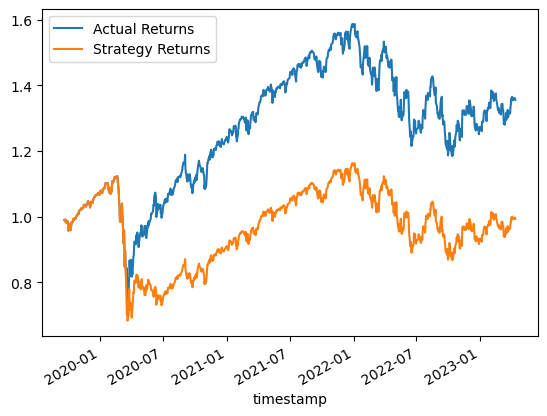

In [25]:
plots = show_plots(predictions_df)
plots

In [26]:
trades = trading_algorithm(predictions_df)
initial_capital = 10000.0
current_capital = initial_capital
shares_owned = 0
buy_price = 0
sell_price = 0
total_trades = 0
winning_trades = 0
losing_trades = 0

journal = pd.DataFrame(columns=["Date", "Action", "Shares", "Price", "Total Value", "Profit/Loss"])

for index, row in trades.iterrows():
    if row["Position"] == 2.0:
        shares_to_buy = int(current_capital / row["close"])
        shares_owned += shares_to_buy
        buy_price = row["close"]
        current_capital -= shares_to_buy * buy_price
        total_trades += 1
        action = "Buy"

    elif row["Position"] == -2.0:
        current_capital += shares_owned * row["close"]
        sell_price = row["close"]
        profit_loss = (sell_price - buy_price) * shares_owned
        if profit_loss >= 0:
            winning_trades += 1
        else:
            losing_trades += 1
        shares_owned = 0
        total_trades += 1
        action = "Sell"

    else:
        action = "Hold"

    journal = journal.append({
        "Date": index,
        "Action": action,
        "Shares": shares_owned,
        "Price": row["close"],
        "Total Value": current_capital + (shares_owned * row["close"]),
        "Profit/Loss": profit_loss if action == "Sell" else None
    }, ignore_index=True)


print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Final Capital: {current_capital + (shares_owned * trades.iloc[-1]['close'])}")

journal.to_csv("Trading Journal.csv", index=False)
import warnings
warnings.filterwarnings("ignore")

Total Trades: 3
Winning Trades: 1
Losing Trades: 0
Final Capital: 13226.83


In [28]:
import yfinance as yf
import pandas as pd
import datetime as dt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def get_sentiment(ticker, start_date, end_date):
    # Step 1: Retrieve news articles for the given ticker and date range
    df_news = yf.Ticker(ticker).get_news('2015-04-16')
    # Step 2: Perform sentiment analysis using VADER
    sia = SentimentIntensityAnalyzer()
    df_news['sentiment'] = df_news['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Step 3: Output the results to a CSV file
    df_news.to_csv(f'{ticker}_sentiment.csv', index=False)

# Example usage
get_sentiment('SPY', dt.datetime(2016, 4, 16), dt.datetime(2022, 4, 19))

ProxyError: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v1/finance/search?q=SPY (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001E6778B66E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')))